<a href="https://colab.research.google.com/github/angga5165/banana-ai-web/blob/main/Preprocessing_dan_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflowjs

In [ ]:
!pip install split-folders

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import collections
import splitfolders

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mengimpor libraries untuk pembuatan dan evaluasi model
import tensorflowjs as tfjs
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, models, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from collections import Counter

from google.colab import files
import urllib.request
import requests
from io import BytesIO
from PIL import Image

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

tf.config.experimental.enable_op_determinism()

In [ ]:
import kagglehub

# 1. Download dataset
path = kagglehub.dataset_download(
    "muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten"
)
print("Dataset downloaded to:", path)

# 2. Set root folder dari dataset
root = os.path.join(path, "Fruit And Vegetable Diseases Dataset")

banana_dir = "./banana_dataset"
os.makedirs(banana_dir, exist_ok=True)

banana_classes = ["Banana__Healthy", "Banana__Rotten"]

for cls in banana_classes:
    src = os.path.join(root, cls)
    dst = os.path.join(banana_dir, cls)

    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
        print(f"Copied: {cls}")
    else:
        print(f"Folder tidak ditemukan: {src}")

print("\n✔ Banana dataset siap di:", banana_dir)

100%|██████████| 4.77G/4.77G [00:47<00:00, 108MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten/versions/1
Copied: Banana__Healthy
Copied: Banana__Rotten

✔ Banana dataset siap di: ./banana_dataset


In [ ]:
print(os.listdir(banana_dir))

['Banana__Healthy', 'Banana__Rotten']


In [ ]:
# Folder hasil copy dataset banana
banana_dir = "banana_dataset"

# Folder tujuan gabungan
combined_data_dir = "combine-images"
os.makedirs(combined_data_dir, exist_ok=True)

# Loop semua kelas (Healthy + Rotten)
for cls in os.listdir(banana_dir):
    src_class = os.path.join(banana_dir, cls)

    if os.path.isdir(src_class):
        dst_class = os.path.join(combined_data_dir, cls)
        os.makedirs(dst_class, exist_ok=True)

        # Copy semua gambar
        for img_file in os.listdir(src_class):
            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                dst_file = os.path.join(dst_class, img_file)
                shutil.copy(os.path.join(src_class, img_file), dst_file)

print("Semua gambar Banana sudah digabung ke folder:", combined_data_dir)

Semua gambar Banana sudah digabung ke folder: combine-images


In [ ]:
print(os.listdir("combine-images"))

['Banana__Healthy', 'Banana__Rotten']


In [ ]:
splitfolders.ratio(
    "combine-images",
    output="split-images",
    seed=SEED,
    ratio=(0.8, 0.1, 0.1)
)

Copying files: 4796 files [00:04, 1075.14 files/s]


In [ ]:
train_dir = os.path.join("split-images", "train")
val_dir   = os.path.join("split-images", "val")
test_dir  = os.path.join("split-images", "test")

print("=== TRAIN SET ===")
for cls in os.listdir(train_dir):
    p = os.path.join(train_dir, cls)
    if os.path.isdir(p):
        print(cls, len(os.listdir(p)))

print("\n=== VAL SET ===")
for cls in os.listdir(val_dir):
    p = os.path.join(val_dir, cls)
    if os.path.isdir(p):
        print(cls, len(os.listdir(p)))

print("\n=== TEST SET ===")
for cls in os.listdir(test_dir):
    p = os.path.join(test_dir, cls)
    if os.path.isdir(p):
        print(cls, len(os.listdir(p)))

=== TRAIN SET ===
Banana__Healthy 1599
Banana__Rotten 2237

=== VAL SET ===
Banana__Healthy 199
Banana__Rotten 279

=== TEST SET ===
Banana__Healthy 201
Banana__Rotten 281


In [ ]:
def remove_non_images(folder):
    for root, dirs, files in os.walk(folder):
        for f in files:
            if not f.lower().endswith(('.jpg', '.jpeg', '.png')):
                os.remove(os.path.join(root, f))
                print(f"Removed: {os.path.join(root, f)}")

remove_non_images(train_dir)
remove_non_images(test_dir)
remove_non_images(val_dir)

In [ ]:
def clean_images(folder):
    for root, dirs, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)
            try:
                with Image.open(path) as img:
                    img = img.convert('RGB')  # convert ke RGB
                    img.save(path)  # simpan ulang
            except Exception:
                os.remove(path)
                print("Removed corrupt image:", path)

clean_images(train_dir)
clean_images(test_dir)
clean_images(val_dir)

In [ ]:
IMG_SIZE = (224, 224)
BATCH = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1
)

val_test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = train_gen.flow_from_directory(
    "split-images/train",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_test_gen.flow_from_directory(
    "split-images/val",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

test_ds = val_test_gen.flow_from_directory(
    "split-images/test",
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False
)

Found 3836 images belonging to 2 classes.
Found 478 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


== Gambar yang sudah di Augmentasi ==


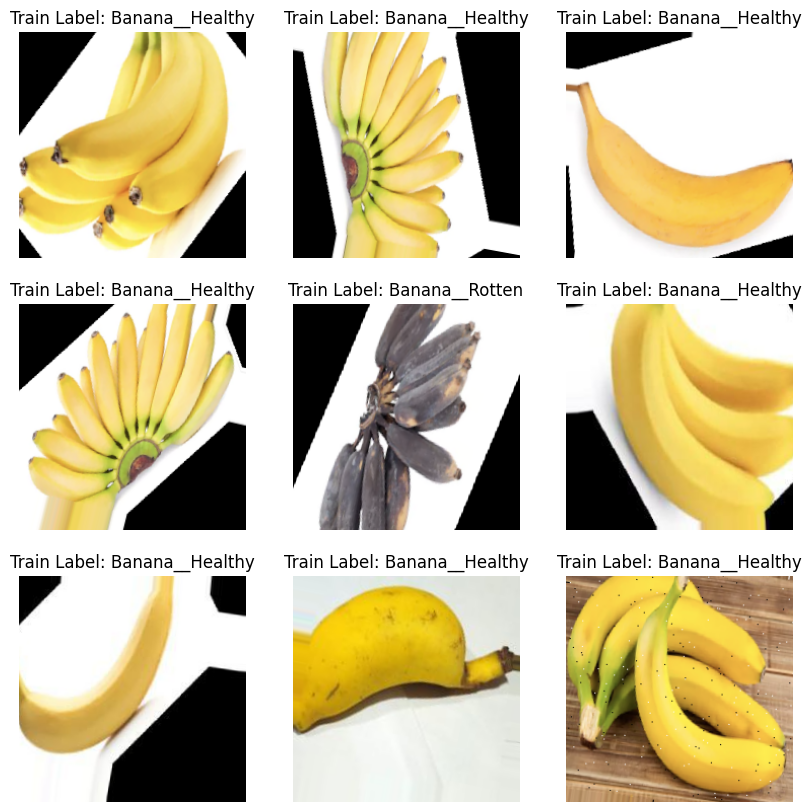

In [ ]:
print("== Gambar yang sudah di Augmentasi ==")

images, one_hot_labels = next(train_ds)

plt.figure(figsize=(10,10))

for idx in range(9):
    plt.subplot(3,3,idx+1)
    img_to_display = images[idx]
    plt.imshow(tf.clip_by_value(img_to_display, 0, 1))

    class_index = np.argmax(one_hot_labels[idx])
    class_names = list(train_ds.class_indices.keys())
    label_name = class_names[class_index]

    plt.title(f"Train Label: {label_name}")
    plt.axis("off")
plt.show()

== Gambar sebelum Augmentasi ==


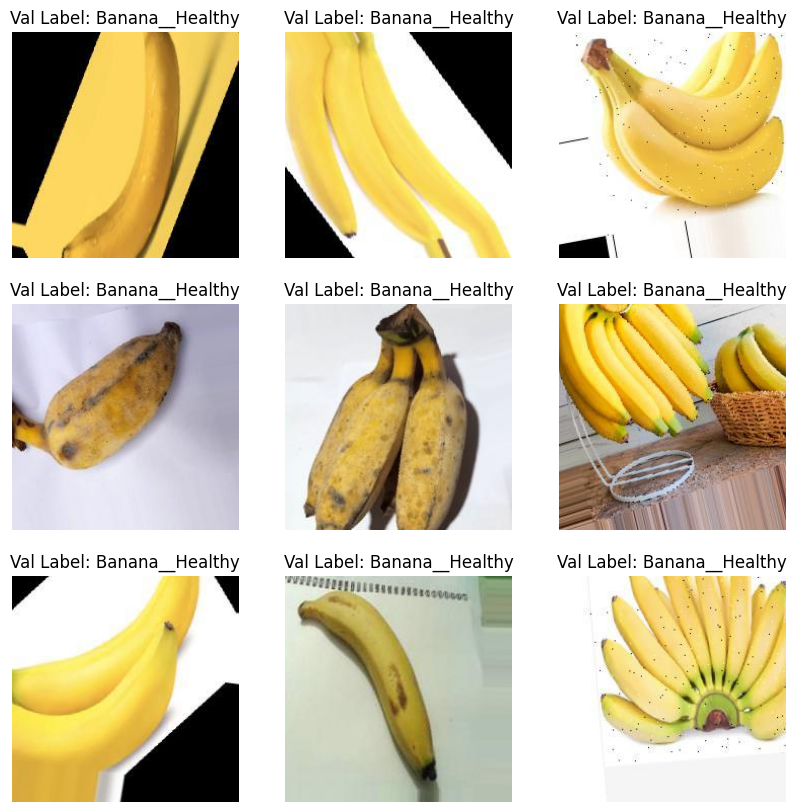

In [ ]:
print("== Gambar sebelum Augmentasi ==")


images_val, one_hot_labels_val = next(val_ds)

plt.figure(figsize=(10,10))

for idx in range(min(9, BATCH)):
    plt.subplot(3,3,idx+1)
    img_to_display = images_val[idx]
    plt.imshow(tf.clip_by_value(img_to_display, 0, 1))

    class_index = np.argmax(one_hot_labels_val[idx])
    class_names = list(val_ds.class_indices.keys())
    label_name = class_names[class_index]

    plt.title(f"Val Label: {label_name}")
    plt.axis("off")
plt.show()

In [ ]:
print("== Normalisasi ==")
for images, labels in val_ds:
    print(images[0][0][0])
    break

== Normalisasi ==
[0. 0. 0.]


In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Get the number of classes from the ImageDataGenerator
num_classes = len(train_ds.class_indices)

model = models.Sequential([
    layers.Input(shape=(224,224,3)),

    # BLOCK 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # BLOCK 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # BLOCK 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 96s 363ms/step - accuracy: 0.8874 - loss: 0.2931 - val_accuracy: 0.4163 - val_loss: 0.8995 - learning_rate: 1.0000e-04
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 85s 353ms/step - accuracy: 0.9672 - loss: 0.1088 - val_accuracy: 0.5983 - val_loss: 0.7105 - learning_rate: 1.0000e-04
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 85s 354ms/step - accuracy: 0.9683 - loss: 0.1057 - val_accuracy: 0.9958 - val_loss: 0.0268 - learning_rate: 1.0000e-04
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 88s 364ms/step - accuracy: 0.9764 - loss: 0.0734 - val_accuracy: 0.9874 - val_loss: 0.0471 - learning_rate: 1.0000e-04
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 85s 356ms/step - accuracy: 0.9823 - loss: 0.0523 - val_accuracy: 0.9916 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 85s 354ms/step - accuracy: 0.9824 - loss: 0.0549 - val_accuracy: 0.9854 - val_loss: 0.0423 - learning_rate: 1.0000e-04
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 85s 35

=== ini evaluasi training set ===
240/240 ━━━━━━━━━━━━━━━━━━━━ 65s 270ms/step - accuracy: 0.9992 - loss: 0.0041
Train Loss: 0.0043
Train Accuracy: 0.9992

 === ini evaluasi test set ===
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0025
Test Loss: 0.0030
Test Accuracy: 1.0000


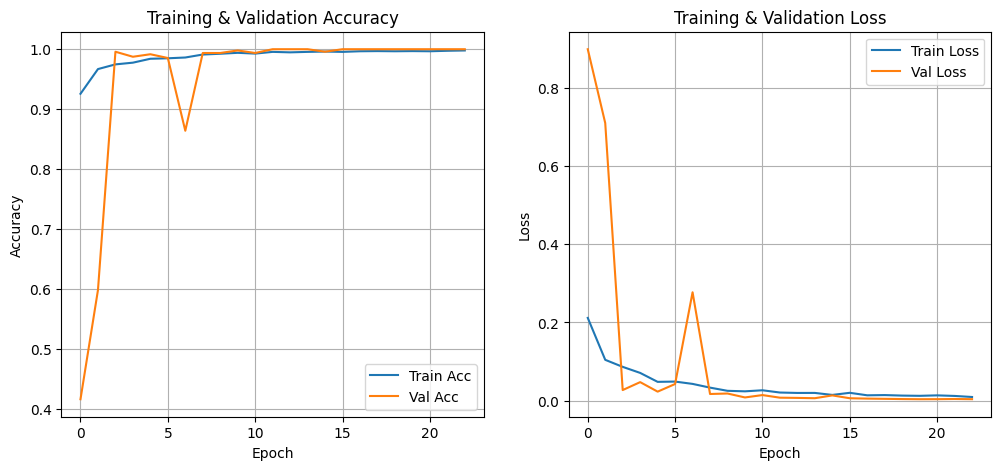

In [ ]:
print('=== ini evaluasi training set ===')
train_loss, train_acc = model.evaluate(train_ds)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_acc:.4f}")

print('\n === ini evaluasi test set ===')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Visualisasi akurasi
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualisasi loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model.save('my_model.keras')

In [ ]:
# Simpan label.txt
labels = list(train_ds.class_indices.keys()) # Menggunakan train_ds untuk mendapatkan nama kelas
with open("label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")
print("label.txt berhasil disimpan!")

label.txt berhasil disimpan!


In [ ]:
!pip install gdown
!gdown --fuzzy "https://drive.google.com/file/d/19OI2zdxF1Ac1KG62Z-iLMQHjxEBfaMrT/view?usp=drive_link" -O pisang_busuk.jpg
!gdown --fuzzy "https://drive.google.com/file/d/1Q52L0YzG7At99GeCUWpBT09aZBe9P7nZ/view?usp=drive_link" -O pisang_sehat.jpg
!gdown --fuzzy "https://drive.google.com/file/d/1JGbIGGgr29hfMRl-o8paVzXqjv1mLJ1v/view?usp=drive_link" -O pisang_sehat2.jpg
!gdown --fuzzy "https://drive.google.com/file/d/1iEFjoSyYtoAfArM6YeZnJ5Iok2bOKEEg/view?usp=drive_link" -O pisang_test.jpg
!gdown --fuzzy "https://drive.google.com/file/d/1Mydyluph7EBupqhIaG1XEQrC7fxo1pDx/view?usp=drive_link" -O pisang_test2.jpg

Downloading...
From: https://drive.google.com/uc?id=19OI2zdxF1Ac1KG62Z-iLMQHjxEBfaMrT
To: /content/pisang_busuk.jpg
100% 39.1k/39.1k [00:00<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q52L0YzG7At99GeCUWpBT09aZBe9P7nZ
To: /content/pisang_sehat.jpg
100% 40.6k/40.6k [00:00<00:00, 58.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JGbIGGgr29hfMRl-o8paVzXqjv1mLJ1v
To: /content/pisang_sehat2.jpg
100% 40.4k/40.4k [00:00<00:00, 88.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iEFjoSyYtoAfArM6YeZnJ5Iok2bOKEEg
To: /content/pisang_test.jpg
100% 159k/159k [00:00<00:00, 116MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mydyluph7EBupqhIaG1XEQrC7fxo1pDx
To: /content/pisang_test2.jpg
100% 78.6k/78.6k [00:00<00:00, 108MB/s]


In [ ]:
# Load model
model = tf.keras.models.load_model("my_model.keras")

# Load gambar
img_path = "pisang_busuk.jpg"
img = image.load_img(img_path, target_size=(224,224))

# Convert ke array
x = image.img_to_array(img)
x = tf.expand_dims(x, axis=0)
x = x / 255.0

# Prediksi
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)
confidence = np.max(pred)

# Load label
with open("label.txt") as f:
    labels = [line.strip() for line in f]

print("Prediksi kelas:", labels[pred_class[0]])
print(f"Confidence: {confidence*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Prediksi kelas: Banana__Rotten
Confidence: 99.94%
